In [1]:
import pandas as pd
import xgboost
import shap
import RDG_interventional
import RDG_gaussian
import numpy as np
import random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split

In [2]:
X, y = shap.datasets.diabetes()
X = (X - np.min(X))/(np.max(X)-np.min(X))
y =  (y - np.min(y))/(np.max(y)-np.min(y))

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'


In [3]:
feature_names = X.columns

In [4]:
correlation_matrix = pd.DataFrame(X).corr().round(2)
correlation_matrix

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
age,1.00,0.17,0.19,0.34,0.26,0.22,-0.08,0.20,0.27,0.30
sex,0.17,1.00,0.09,0.24,0.04,0.14,-0.38,0.33,0.15,0.21
bmi,0.19,0.09,1.00,0.40,0.25,0.26,-0.37,0.41,0.45,0.39
bp,0.34,0.24,0.40,1.00,0.24,0.19,-0.18,0.26,0.39,0.39
s1,0.26,0.04,0.25,0.24,1.00,0.90,0.05,0.54,0.52,0.33
s2,0.22,0.14,0.26,0.19,0.90,1.00,-0.20,0.66,0.32,0.29
s3,-0.08,-0.38,-0.37,-0.18,0.05,-0.20,1.00,-0.74,-0.40,-0.27
s4,0.20,0.33,0.41,0.26,0.54,0.66,-0.74,1.00,0.62,0.42
s5,0.27,0.15,0.45,0.39,0.52,0.32,-0.40,0.62,1.00,0.46
s6,0.30,0.21,0.39,0.39,0.33,0.29,-0.27,0.42,0.46,1.00


In [5]:
X = X.values

In [6]:
np.corrcoef(X)

array([[ 1.        , -0.52672621,  0.94148605, ...,  0.83830129,
        -0.46252558, -0.67540707],
       [-0.52672621,  1.        , -0.33901554, ..., -0.33896964,
         0.1135086 ,  0.71634879],
       [ 0.94148605, -0.33901554,  1.        , ...,  0.86315045,
        -0.57441881, -0.5686937 ],
       ...,
       [ 0.83830129, -0.33896964,  0.86315045, ...,  1.        ,
        -0.73322925, -0.45618217],
       [-0.46252558,  0.1135086 , -0.57441881, ..., -0.73322925,
         1.        ,  0.20004835],
       [-0.67540707,  0.71634879, -0.5686937 , ..., -0.45618217,
         0.20004835,  1.        ]])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
from sklearn.ensemble import RandomForestRegressor
#clf = GradientBoostingRegressor(n_estimators=10, learning_rate=0.6,max_depth=3, random_state=0).fit(X_train, y_train)
from sklearn.linear_model import LinearRegression
#clf = LinearRegression().fit(X_train, y_train)
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(max_depth=10, random_state=0).fit(X, y)
print(clf.score(X_test, y_test))

cov = np.cov(X.T)
means = X.mean(axis=0)

minis = np.min(X,axis=0)
maxis = np.max(X,axis=0)

0.8933470915702475


ground_truth = {}
for i in range(0,len(clf.coef_[0])):
    ground_truth[i] = np.abs(clf.coef_[0][i])
sorted_indexes = sorted(ground_truth, key=ground_truth.get,reverse=True)
sorted_indexes

In [8]:
explainer = shap.Explainer(clf)
og_shap_values = explainer(X_test)

In [9]:
e = shap.KernelExplainer(clf.predict, X_train[0:10])
ks_shap_values = e.shap_values(X_test)

  0%|          | 0/133 [00:00<?, ?it/s]

In [10]:
X_test.shape

(133, 10)

In [59]:
overall_ss_g_sum_indexes = []
overall_ss_i_sum_indexes = []
overall_ks_sum_indexes = []
overall_og_sum_indexes = []
overall_tree_sum_indexes = []

overall_ss_g_indexes = []
overall_ss_i_indexes = []
overall_ks_indexes = []
overall_og_indexes = []
overall_tree_indexes = []

ss_g_scores = []
ss_i_scores = []
ks_scores = []
og_scores = []
#tree_scores = []
for a in range(10,13):
    x = X_test[a]
    ss_i_atts,seps,nonseps = RDG_interventional.RDG(clf.predict,x,means,minis,maxis,0.1)
    ss_g_atts,seps,nonseps = RDG_gaussian.RDG(clf.predict,x,means,cov,minis,maxis,0.04,X)
    
    ks_atts = {}
    for val in range(0,len(ks_shap_values[a])):
        ks_atts[val] = ks_shap_values[a][val]
    
    og_atts = {}
    for val in range(0,len(og_shap_values[a].values)):
        og_atts[val] = og_shap_values[a].values[val]
        
    #tree_atts = {}
    #for val in range(0,len(tree_shap_values[a])):
        #tree_atts[val] = tree_shap_values[a][val]

    temp = {}
    for u in ss_i_atts.keys():
        temp[u] = np.abs(ss_i_atts[u])
    sorted_ss_i_indexes = sorted(temp, key=temp.get, reverse=True)
    
    temp = {}
    for u in ss_g_atts.keys():
        temp[u] = np.abs(ss_g_atts[u]) 
    sorted_ss_g_indexes = sorted(temp, key=temp.get, reverse=True)
    
    temp = {}
    for u in ks_atts.keys():
        temp[u] = np.abs(ks_atts[u]) 
    sorted_ks_indexes = sorted(temp, key=temp.get, reverse=True)
    
    temp = {}
    for u in og_atts.keys():
        temp[u] = np.abs(og_atts[u]) 
    sorted_og_indexes = sorted(temp, key=temp.get, reverse=True)
    
    #temp = {}
    #for u in tree_atts.keys():
       # temp[u] = np.abs(tree_atts[u]) 
    #sorted_tree_indexes = sorted(temp, key=temp.get, reverse=True)
    
    overall_ss_g_indexes.append(sorted_ss_g_indexes[0])
    overall_ss_i_indexes.append(sorted_ss_i_indexes[0])
    overall_ks_indexes.append(sorted_ks_indexes[0])
    overall_og_indexes.append(sorted_og_indexes[0])
    #overall_tree_indexes.append(sorted_tree_indexes[0])
    
    total_sum = clf.predict(x.reshape(1,-1))[0] -  clf.predict(means.reshape(1,-1))[0]

    overall_ss_i_sum_indexes.append(sum(ss_i_atts.values())[0] - total_sum)
    overall_ss_g_sum_indexes.append(sum(ss_g_atts.values())[0] - total_sum)
    overall_ks_sum_indexes.append(sum(ks_atts.values()) - total_sum)
    overall_og_sum_indexes.append(sum(og_atts.values()) - total_sum)
    
    
    ind = sorted_ss_g_indexes[0]
    new_x = x.copy()
    if len(list(ind)) > 1:
        for u in list(ind):
            new_x[u] = means[u]
    else:
        new_x[list(ind)[0]] = means[list(ind)[0]]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
    ss_g_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))
    
    ind = sorted_ss_i_indexes[0]
    new_x = x.copy()
    if len(list(ind)) > 1:
        for u in list(ind):
            new_x[u] = means[u]
    else:
        new_x[list(ind)[0]] = means[list(ind)[0]]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
    ss_i_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))
    
    ind = sorted_ks_indexes[0]
    new_x = x.copy()
    
    new_x[ind] = means[ind]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
    ks_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))
    
    
    ind = sorted_og_indexes[0]
    new_x = x.copy()
    
    new_x[ind] = means[ind]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
   
    
    og_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))
    
    
    """ind = sorted_tree_indexes[0]
    new_x = x.copy()
    
    new_x[ind] = means[ind]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
    tree_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))"""
            

in here

in here

in here



In [60]:
print('interventional')
print('sum')
print(np.mean(overall_ss_i_sum_indexes))
print(np.std(overall_ss_i_sum_indexes))

print('faithfulness')
print(np.mean(ss_i_scores))
print(np.std(ss_i_scores))

print('gaussian conditional')

print('sum')
print(np.mean(overall_ss_g_sum_indexes))
print(np.std(overall_ss_g_sum_indexes))

print('faithfulness')
print(np.mean(ss_g_scores))
print(np.std(ss_g_scores))

print('KS')

print('sum')
print(np.mean(overall_ks_sum_indexes))
print(np.std(overall_ks_sum_indexes))

print('faithfulness')
print(np.mean(ks_scores))
print(np.std(ks_scores))

print('Tree')

print('sum')
print(np.mean(overall_og_sum_indexes))
print(np.std(overall_og_sum_indexes))

print('faithfulness')
print(np.mean(og_scores))
print(np.std(og_scores))

print(" ")
print("ATTS:")

print("")

og_label_atts = {}
for i in range(0,len(feature_names)):
    og_label_atts[feature_names[i]] = og_atts[i]
print("tree atts")
print(og_label_atts)

ks_label_atts = {}
for i in range(0,len(feature_names)):
    ks_label_atts[feature_names[i]] = ks_atts[i]
print("ks atts")
print(ks_label_atts)

ss_i_atts
i_label_atts = {}
for u in ss_i_atts.keys():
    label = []
    for i in list(u):
        label.append(feature_names[i])
    i_label_atts[tuple(label)] = ss_i_atts[u][0]

print('i_label_atts')
print(i_label_atts)

ss_g_atts
g_label_atts = {}
for u in ss_g_atts.keys():
    label = []
    for i in list(u):
        label.append(feature_names[i])
    g_label_atts[tuple(label)] = ss_g_atts[u][0]
g_label_atts
print('g_label_atts')
print(g_label_atts)

interventional
sum
-0.02220251998348044
0.02777989327827834
faithfulness
0.17866303935297703
0.05416718276608966
gaussian conditional
sum
-0.3769534595240304
0.14503557231859254
faithfulness
0.04305679995384737
0.046148140761369444
KS
sum
-0.06531067021371773
0.0
faithfulness
0.21577987035469445
0.08346001954645035
Tree
sum
-0.07638011507716737
9.31467358497575e-16
faithfulness
0.21577987035469445
0.08346001954645035
 
ATTS:

tree atts
{'age': 0.007338379399331874, 'sex': 0.0028335960500482085, 'bmi': 0.11228597019871572, 'bp': 0.0373888157358512, 's1': 0.012880905121696921, 's2': 0.010599527622829773, 's3': 0.0010051654015588826, 's4': -0.009838297091238254, 's5': 0.11535548000317711, 's6': 0.002938581439792623}
ks atts
{'age': 0.006000559547357761, 'sex': 0.003502207710868137, 'bmi': 0.09285970098560664, 'bp': 0.04491970590902338, 's1': 0.011904066642628096, 's2': 0.011558394135306365, 's3': 0.0043136084186379525, 's4': -0.004722149543309175, 's5': 0.12852931085941643, 's6': 0.004992

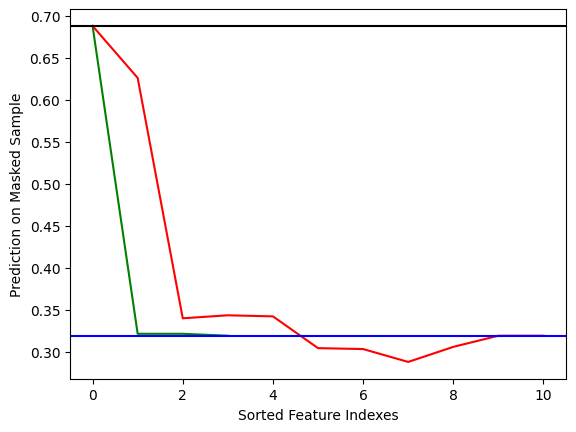

In [62]:
new_predictions_i = []
new_x = x.copy()
new_predictions_i.append(clf.predict(x.reshape(1,-1))[0])
for u in sorted_ss_g_indexes:
    for i in u:
        new_x[i] = means[i]
    new_predictions_i.append(clf.predict(new_x.reshape(1,-1))[0])
new_predictions_i

new_predictions_ks = []
new_x = x.copy()
new_predictions_ks.append(clf.predict(x.reshape(1,-1))[0])
for u in sorted_ks_indexes:

    new_x[u] = means[u]
    new_predictions_ks.append(clf.predict(new_x.reshape(1,-1))[0])
new_predictions_ks

import matplotlib.pyplot as plt
plt.plot(new_predictions_i,color='green')
plt.plot(new_predictions_ks,color='red')
plt.axhline(y = clf.predict(means.reshape(1,-1))[0] , color = 'blue')

plt.axhline(y = clf.predict(x.reshape(1,-1))[0] , color = 'black')
plt.xlabel('Sorted Feature Indexes')
plt.ylabel('Prediction on Masked Sample')
#plt.axvline(x = 8, color = 'green')
#plt.axvline(x = 12, color = 'red')
plt.savefig('diabetes23_cond.pdf')